# Inspect Ego4D SCOD Test-Set

In [2]:
import csv, os, sys, re, string, json, glob, shutil, random, datetime, math, pprint
from itertools import combinations

import torch
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm

from IPython.display import HTML as html_print
from IPython.display import Markdown
from IPython.display import clear_output

# from IPython.display import Image
from PIL import Image, ImageDraw, ImageFont
from ipywidgets import Video

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set()
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%pylab inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Functions

In [3]:
def red_text(text):
    return "\x1b[31m" + text + "\x1b[0m"

def blue_text(text):
    return "\x1b[94m" + text + "\x1b[0m"

def green_text(text):
    return "\x1b[32m" + text + "\x1b[0m"

def magenta_text(text):
    return "\x1b[35m" + text + "\x1b[0m"

def yellow_text(text):
    return "\x1b[93m" + text + "\x1b[0m"

def bg_yellow_text(text):
    return "\x1b[43m" + text + "\x1b[0m"

def bg_magenta_text(text):
    return "\x1b[45m" + text + "\x1b[0m"

def bg_green_text(text):
    return "\x1b[46m" + text + "\x1b[0m"

def bg_blue_text(text):
    return "\x1b[44m" + text + "\x1b[0m"

def bold_text(text):
    return "\x1b[1;128m" + text + "\x1b[0m"

In [4]:
def extract_ego4d_scod_clips(
    sampled_scod_clip,
    curr_videos_root,
    video_scenarios,
    all_narrations,
    tmp_video_name="scod_clip.mp4",
    tmp_video_folder="./media",
    extra_seconds_to_cut=None,
    ffmpeg_extract_video=True,
    verbose=False,
):
    video_uid = sampled_scod_clip["video_uid"]
    ego4d_video_path = os.path.join(
        curr_videos_root,
        "{}.mp4".format(video_uid),
    )
    summary = "N/A"
    if "narration_pass_1" in all_narrations[video_uid]:
        if len(all_narrations[video_uid]["narration_pass_1"]["summaries"]) > 0:
            summary = []
            for i in range(len(all_narrations[video_uid]["narration_pass_1"]["summaries"])):
                summary.append(all_narrations[video_uid]["narration_pass_1"]["summaries"][i]["summary_text"])
            summary = " ".join(summary)
    if verbose:
        print("{}: {}".format(bold_text("Mother video"), ego4d_video_path))
        video_scenario = video_scenarios[video_uid]
        if len(video_scenario) > 0:
            video_scenario = video_scenario[0]
        else:
            video_scenario = "N/A"
        print("{}: {}".format(bold_text("Mother video summary"), summary))
        print("{}: {}".format(bold_text("Mother video scenario"), video_scenario))

    cap = cv2.VideoCapture(ego4d_video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = float(frame_cnt) / float(fps)
    cap.release()

    if verbose:
        print(
            "The fps of the video is: {} of frame counts: {} "
            "and duration: {:.3f} sec.".format(fps, frame_cnt, duration)
        )

    pre_frame = sampled_scod_clip["pre_frame"]["frame_number"]
    pnr_frame = sampled_scod_clip["pnr_frame"]["frame_number"]
    pos_frame = sampled_scod_clip["post_frame"]["frame_number"]

    pre_secs = pre_frame / fps
    pnr_secs = pnr_frame / fps
    pos_secs = pos_frame / fps

    pre_secs = math.floor(pre_secs)
    pos_secs = math.ceil(pos_secs)
    pre_timestamp = str(datetime.timedelta(seconds=pre_secs))
    pnr_timestamp = str(datetime.timedelta(seconds=pnr_secs))
    pos_timestamp = str(datetime.timedelta(seconds=pos_secs))

    if verbose:
        print("{}:  time={} frame={}".format(bold_text("Pre-Frame"), pre_timestamp, pre_frame))
        print("{}:  time={} frame={}".format(bold_text("PNR-Frame"), pnr_timestamp, pnr_frame))
        print("{}: time={} frame={}".format(bold_text("Post-Frame"), pos_timestamp, pos_frame))

    total_video_secs = (pos_secs - pre_secs)
        
    if extra_seconds_to_cut is not None:
        assert type(extra_seconds_to_cut) is tuple and type(extra_seconds_to_cut[0]) is float
        assert len(extra_seconds_to_cut) == 2
        extra_pre_seconds_to_cut, extra_post_seconds_to_cut = extra_seconds_to_cut
        pre_timestamp = str(datetime.timedelta(seconds=max(0, pre_secs-extra_pre_seconds_to_cut)))
        pos_timestamp = str(datetime.timedelta(seconds=pos_secs+extra_post_seconds_to_cut))
        total_video_secs += (extra_pre_seconds_to_cut + extra_post_seconds_to_cut)
        if verbose:
            print(
                "{}".format(
                    red_text("Extending {} secs front and {} "
                             "secs rare.".format(extra_pre_seconds_to_cut, extra_post_seconds_to_cut)))
            )

    # pre_timestamp_secs = math.floor(float(pre_timestamp.split(":")[-1]))
    # pos_timestamp_secs = math.ceil(float(pos_timestamp.split(":")[-1]))
    pre_timestamp_secs = pre_timestamp.split(":")[-1]
    pos_timestamp_secs = pos_timestamp.split(":")[-1]

    pre_timestamp = ":".join(pre_timestamp.split(":")[:-1]) + ":" + str(pre_timestamp_secs)
    pos_timestamp = ":".join(pos_timestamp.split(":")[:-1]) + ":" + str(pos_timestamp_secs)


    if ffmpeg_extract_video:
        if not os.path.exists(tmp_video_folder):
            os.makedirs(tmp_video_folder)
        tmp_video_path = os.path.join(tmp_video_folder, tmp_video_name)
        if os.path.exists(tmp_video_path):
            os.remove(tmp_video_path)
        ffmpeg_video_cmd = (
            "/home/telinwu/ffmpeg-git-20220910-amd64-static/ffmpeg -ss {} -to {} "
            "-i {} -vcodec libx264 -c copy -loglevel panic {}".format(
                pre_timestamp,
                pos_timestamp,
                ego4d_video_path,
                tmp_video_path,
            )
        )
        os.system(ffmpeg_video_cmd)
        if verbose:
            print("{}: {}".format(bold_text(blue_text("Executed video extracting command")),
                                  blue_text(ffmpeg_video_cmd)))
            print("Total video time: {:.3f}".format(total_video_secs))

    return video_uid, {"pre_frame": pre_frame, "pnr_frame": pnr_frame, "post_frame": pos_frame}, total_video_secs
    
    
def get_scod_clipped_narrations(
    scod_clip,
    all_narrations,
    curr_videos_root,
    narration_pass="narration_pass_1",
    anchor_frame="pre",
    top_k=5,
    strict_overlapping=False,
    verbose=False,
    show_all_narrations=False,
):    
    video_uid = scod_clip["video_uid"]
    ego4d_video_path = os.path.join(
        curr_videos_root,
        "{}.mp4".format(video_uid),
    )

    cap = cv2.VideoCapture(ego4d_video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = float(frame_cnt) / float(fps)
    cap.release()
    
    clip_uid = scod_clip["clip_uid"]
    pre_frame = scod_clip["pre_frame"]
    pnr_frame = scod_clip["pnr_frame"]
    pos_frame = scod_clip["post_frame"]
    if narration_pass not in all_narrations[video_uid]:
        return []
    curr_narrations = all_narrations[video_uid][narration_pass]["narrations"]
    
    pre_frame_num = pre_frame["frame_number"]
    pnr_frame_num = pnr_frame["frame_number"]
    pos_frame_num = pos_frame["frame_number"]
    
    pre_frame_sec = round(pre_frame_num/fps, 2)
    pnr_frame_sec = round(pnr_frame_num/fps, 2)
    pos_frame_sec = round(pos_frame_num/fps, 2)
    
    closest_narrations = []
    for i in range(len(curr_narrations)-1):
        timestamp_sec = curr_narrations[i]["timestamp_sec"]
        timestamp_frame = curr_narrations[i]["timestamp_frame"]
        next_timestamp_sec = curr_narrations[i+1]["timestamp_sec"]
        next_timestamp_frame = curr_narrations[i+1]["timestamp_frame"]
        narration_text = curr_narrations[i]["narration_text"]
        anchor_frame_num = scod_clip["{}_frame".format(anchor_frame)]["frame_number"]
        
        if show_all_narrations:
            print("[{}-{}] {}".format(timestamp_frame, next_timestamp_frame, narration_text))

        closest_narrations.append((
            abs(timestamp_frame-anchor_frame_num),
            timestamp_sec, timestamp_frame,
            next_timestamp_sec, next_timestamp_frame,
            narration_text,
        ))

    closest_narrations = sorted(closest_narrations)[:top_k]
    closest_narrations = [(a, b, c, d, e) for _, a, b, c, d, e in closest_narrations]

    tagged_closest_narrations = []
    for a, b, c, d, e in closest_narrations:
        tag, tag_str = False, ""
        if (b > pre_frame_num and b < pos_frame_num) or (d > pre_frame_num and d < pos_frame_num):
            tag, tag_str = True, "(v)"

        overlapping = len(
            range(
                max(pre_frame_num, b),
                min(pos_frame_num, d) + 1
            )
        )
        if strict_overlapping and overlapping <= 0:
            continue

        if verbose:
            print(
                "[{}-{}]({}-{}) {} {}".format(
                    str(datetime.timedelta(seconds=a))[:10],
                    str(datetime.timedelta(seconds=c))[:10],
                    b, d, e, tag_str,
                )
            )
        tagged_closest_narrations.append((tag, a, b, c, d, e))
    
    return tagged_closest_narrations


def refine_or_trim_ego4d_narration(
        narration,
        remove_hand_desc=False,
    ):
    if narration is None:
        return None
    tokens = narration.split()
    character_symbol = None
    if "#" in tokens[0]:
        character_symbol = tokens[0].split("#")[-1]
    filtered_tokens = []
    for t in tokens:
        if "#" in t or (character_symbol is not None and t == character_symbol):
            continue
        if len(t) == 0:
            continue
        filtered_tokens.append(t)
    narration = " ".join(filtered_tokens)
    narration_tokens = narration.split()  # Remove white excessive white spaces.
    narration_tokens = [t for t in narration_tokens if len(t) != 0]
    narration = " ".join(narration_tokens)
    narration = narration.strip()
    if character_symbol is not None and character_symbol.lower() == "c":
        narration = "A person " + narration
    else:
        # print("No character symbol: {}".format(narration))
        pass
    if remove_hand_desc:
        regex_str = (
            "\ (?:in|with|using|into|from)\ (?:his|her|the|their|both|a)?\s*"
            "(?:gloved)?\s*(?:right|left|two|both|of)?\s*"
            "(?:his|her|the|their|gloved)?\s*"
            "(?:hands|hand|arms|arm)"
        )
        m = re.search(regex_str, narration)
        while m is not None:
            hand_str = m.group()
            narration = narration.replace(hand_str, "")
            m = re.search(regex_str, narration)
    return narration

# SCOD Data

In [5]:
# Use annotations to filter out the videos list we want.
annots_root = "/local1/hu528/ego4d_data/v1/annotations/"
annots_root = "/home/telinwu/ego4d_data/v1/annotations/"
curr_videos_root = "/local1/hu528/ego4d_data/v1/full_scale"

video_info_file = "/local1/hu528/ego4d_data/ego4d.json"
video_info = json.load(open(video_info_file))
info_videos = video_info["videos"]
video_scenarios = {x["video_uid"]: x["scenarios"] for x in info_videos}

all_narrations_file = os.path.join(annots_root, "narration.json")
all_narrations = json.load(open(all_narrations_file))

In [6]:
# Get the SCOD challenge train-val sets.
scod_train_file = "fho_scod_train.json"
scod_train_file = os.path.join(annots_root, scod_train_file)
scod_train_data = json.load(open(scod_train_file))
scod_train_clips = scod_train_data["clips"]

scod_val_file = "fho_scod_val.json"
scod_val_file = os.path.join(annots_root, scod_val_file)
scod_val_data = json.load(open(scod_val_file))
scod_val_clips = scod_val_data["clips"]

scod_test_file = "fho_scod_test_unannotated.json"
scod_test_file = os.path.join(annots_root, scod_test_file)
scod_test_data = json.load(open(scod_test_file))
scod_test_clips = scod_test_data["clips"]

scod_clips = {
    "train": scod_train_clips,
    "val": scod_val_clips,
    "test": scod_test_clips,
}

downloaded_video_id_and_paths = {
    x.split(".mp4")[0]: os.path.join(curr_videos_root, x)
    for x in os.listdir(curr_videos_root) if ".mp4" in x
}
print("Currently we downloaded {} ego4d videos.".format(len(downloaded_video_id_and_paths)))

downloaded_scod_clips = {
    "train": [],
    "val": [],
    "test": [],
}
split_video_uids = {
    "train": [],
    "val": [],
    "test": [],
}
for split in scod_clips:
    for scod_clip in scod_clips[split]:
        video_uid = scod_clip["video_uid"]
        if video_uid in downloaded_video_id_and_paths:
            downloaded_scod_clips[split].append(scod_clip)
        if video_uid not in split_video_uids[split]:
            split_video_uids[split].append(video_uid)
    print(
        "There are {}/{} clips available for scod {}.".format(
            len(downloaded_scod_clips[split]),
            len(scod_clips[split]),
            split
        )
    )
    print("The {} split has {} unique Ego4D videos.".format(split, len(split_video_uids[split])))

Currently we downloaded 926 ego4d videos.
There are 19071/19071 clips available for scod train.
The train split has 457 unique Ego4D videos.
There are 12801/12801 clips available for scod val.
The val split has 346 unique Ego4D videos.
There are 662898/662898 clips available for scod test.
The test split has 333 unique Ego4D videos.


## Inspections (Test Set)

In [8]:
from tqdm import tqdm

total_num = 0
all_captions = []

for key, value in tqdm(pre_generated_captions_testset.items()):
    total_num += 1
    if value not in all_captions:
        all_captions.append(value)
        
    if total_num % 10000 == 0:
        print(total_num)
        print(len(all_captions))
        
print(total_num)
print(len(all_captions))

  1%|▉                                                             | 7800/543588 [00:00<00:06, 77985.76it/s]

10000
1853


  4%|██▍                                                          | 22042/543588 [00:01<00:39, 13300.43it/s]

20000
3060


  6%|███▌                                                          | 30796/543588 [00:02<01:04, 7912.53it/s]

30000
5000


  7%|████▋                                                         | 40613/543588 [00:04<01:37, 5141.54it/s]

40000
6357


  9%|█████▊                                                        | 50519/543588 [00:06<02:01, 4048.03it/s]

50000
8001


 11%|██████▉                                                       | 60465/543588 [00:10<02:22, 3387.35it/s]

60000
9571


 13%|████████                                                      | 70563/543588 [00:13<03:55, 2012.44it/s]

70000
11048


 15%|█████████▏                                                    | 80362/543588 [00:17<03:01, 2557.46it/s]

80000
12501


 17%|██████████▎                                                   | 90353/543588 [00:21<03:21, 2250.20it/s]

90000
13801


 18%|███████████▎                                                 | 100341/543588 [00:26<03:36, 2045.53it/s]

100000
15102


 20%|████████████▎                                                | 110231/543588 [00:32<03:59, 1808.16it/s]

110000
16906


 22%|█████████████▍                                               | 120203/543588 [00:38<04:12, 1677.48it/s]

120000
18715


 24%|██████████████▌                                              | 130291/543588 [00:45<04:27, 1546.40it/s]

130000
20083


 26%|███████████████▋                                             | 140246/543588 [00:52<04:44, 1419.72it/s]

140000
21419


 28%|████████████████▊                                            | 150200/543588 [01:00<05:10, 1266.31it/s]

150000
22426


 29%|█████████████████▉                                           | 160189/543588 [01:08<05:01, 1272.29it/s]

160000
24307


 31%|███████████████████                                          | 170203/543588 [01:17<05:10, 1203.36it/s]

170000
26113


 33%|████████████████████▏                                        | 180221/543588 [01:26<05:17, 1146.16it/s]

180000
27553


 35%|█████████████████████▎                                       | 190127/543588 [01:35<04:49, 1222.62it/s]

190000
28546


 37%|██████████████████████▍                                      | 200200/543588 [01:45<05:29, 1043.01it/s]

200000
30131


 39%|███████████████████████▉                                      | 210167/543588 [01:55<05:34, 996.23it/s]

210000
31328


 40%|█████████████████████████                                     | 220112/543588 [02:05<05:45, 936.58it/s]

220000
33217


 42%|██████████████████████████▏                                   | 230134/543588 [02:16<05:47, 900.79it/s]

230000
34840


 44%|███████████████████████████▍                                  | 240156/543588 [02:28<06:06, 828.47it/s]

240000
36601


 46%|████████████████████████████▌                                 | 250093/543588 [02:40<05:45, 848.79it/s]

250000
37988


 48%|█████████████████████████████▋                                | 260158/543588 [02:52<05:57, 792.07it/s]

260000
39529


 50%|██████████████████████████████▊                               | 270136/543588 [03:05<05:47, 787.83it/s]

270000
41021


 52%|███████████████████████████████▉                              | 280104/543588 [03:18<05:53, 745.03it/s]

280000
43144


 53%|█████████████████████████████████                             | 290124/543588 [03:32<05:28, 771.82it/s]

290000
44216


 55%|██████████████████████████████████▏                           | 300074/543588 [03:45<05:46, 702.70it/s]

300000
45561


 57%|███████████████████████████████████▎                          | 310142/543588 [04:00<05:09, 753.78it/s]

310000
47129


 59%|████████████████████████████████████▌                         | 320078/543588 [04:15<05:42, 652.44it/s]

320000
48439


 61%|█████████████████████████████████████▋                        | 330116/543588 [04:31<06:50, 520.28it/s]

330000
49442


 63%|██████████████████████████████████████▊                       | 340092/543588 [04:47<05:38, 601.68it/s]

340000
50933


 64%|███████████████████████████████████████▉                      | 350061/543588 [05:04<05:24, 595.55it/s]

350000
51540


 66%|█████████████████████████████████████████                     | 360076/543588 [05:21<05:20, 572.97it/s]

360000
53079


 68%|██████████████████████████████████████████▏                   | 370059/543588 [05:39<05:01, 574.67it/s]

370000
54368


 70%|███████████████████████████████████████████▎                  | 380050/543588 [05:57<06:41, 407.54it/s]

380000
55887


 72%|████████████████████████████████████████████▍                 | 390069/543588 [06:16<04:54, 520.65it/s]

390000
58389


 74%|█████████████████████████████████████████████▋                | 400071/543588 [06:36<04:55, 485.99it/s]

400000
59935


 75%|██████████████████████████████████████████████▊               | 410050/543588 [06:55<04:38, 479.28it/s]

410000
61304


 77%|███████████████████████████████████████████████▉              | 420061/543588 [07:16<04:21, 471.52it/s]

420000
62356


 79%|█████████████████████████████████████████████████             | 430059/543588 [07:39<06:05, 310.41it/s]

430000
63922


 81%|██████████████████████████████████████████████████▏           | 440049/543588 [08:03<04:03, 425.09it/s]

440000
64974


 83%|███████████████████████████████████████████████████▎          | 450080/543588 [08:26<03:40, 423.37it/s]

450000
66328


 85%|████████████████████████████████████████████████████▍         | 460074/543588 [08:50<03:35, 387.73it/s]

460000
67702


 86%|█████████████████████████████████████████████████████▌        | 470065/543588 [09:16<03:08, 389.77it/s]

470000
69800


 88%|██████████████████████████████████████████████████████▊       | 480066/543588 [09:43<02:56, 360.26it/s]

480000
71506


 90%|███████████████████████████████████████████████████████▉      | 490039/543588 [10:10<02:31, 354.57it/s]

490000
72550


 92%|█████████████████████████████████████████████████████████     | 500056/543588 [10:39<02:03, 353.67it/s]

500000
74456


 94%|██████████████████████████████████████████████████████████▏   | 510038/543588 [11:09<01:52, 298.42it/s]

510000
76142


 96%|███████████████████████████████████████████████████████████▎  | 520055/543588 [11:41<01:16, 309.43it/s]

520000
77617


 98%|████████████████████████████████████████████████████████████▍ | 530043/543588 [12:14<00:43, 314.60it/s]

530000
79110


 99%|█████████████████████████████████████████████████████████████▌| 540044/543588 [12:51<00:12, 281.81it/s]

540000
81109


100%|██████████████████████████████████████████████████████████████| 543588/543588 [13:04<00:00, 692.80it/s]

543588
81463


In [7]:
pre_generated_captions_file = (
    "/home/telinwu/research/project_jarvis/modeling/glip_result_json_files/scod_testset_lavis_captions.json"
)
pre_generated_captions_testset = json.load(open(pre_generated_captions_file))

In [57]:
image_root = "/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge/pre_pnr_post_frames"
split = "test"

Mother video: 2911c0de-45ad-488a-a8e7-a445d37568ad
--------------------------------------------------
Frame: pre_frame  Number: 2933


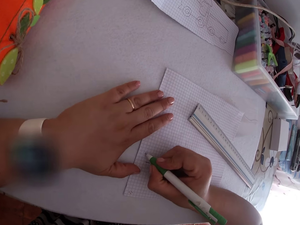

--------------------------------------------------
Frame: pnr_frame  Number: 3980


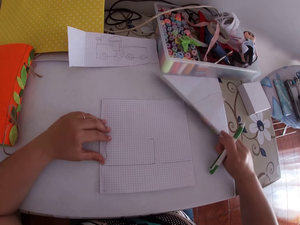

BLIPv2-Caption-1: a person cutting something out of paper with a pair of scissors
--------------------------------------------------
Frame: post_frame  Number: 5108


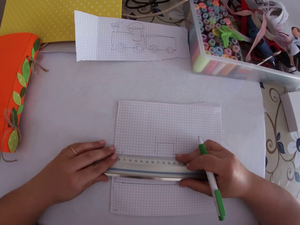

--------------------------------------------------


In [68]:
rand_idx = np.random.randint(len(downloaded_scod_clips[split]))
resize_image_width = 300

curr_scod_clip = downloaded_scod_clips[split][rand_idx]
video_uid = curr_scod_clip["video_uid"]
print("Mother video: {}".format(video_uid))
print("-"*50)
for fr in ["pre", "pnr", "post"]:
    fr_name = "{}_frame".format(fr)
    fr_info = curr_scod_clip[fr_name]
    frame_num = fr_info["frame_number"]
    image_path = os.path.join(image_root, video_uid, str(frame_num)+".jpg")
    print("{} {}  {} {}".format(bold_text("Frame:"), fr_name, bold_text("Number:"), frame_num))
    # print(image_path)
    img = Image.open(image_path)
    if resize_image_width is not None:
        wpercent = (resize_image_width / float(img.size[0]))
        hsize = int((float(img.size[1]) * float(wpercent)))
        img = img.resize(
            (resize_image_width, hsize), Image.Resampling.LANCZOS)
    display(img)
    if fr == "pnr":
        file_name = os.path.join(video_uid, str(frame_num)+".jpg")
        assert file_name in pre_generated_captions_testset, (
            "File name: `{}` does not have pre-generated captions!".format(file_name)
        )
        curr_pre_generated_captions = pre_generated_captions_testset[file_name]
        for idx in range(len(curr_pre_generated_captions)):
            curr_curr_pre_generated_caption = curr_pre_generated_captions[idx]
            print("{} {}".format(bold_text(blue_text("BLIPv2-Caption-{}:".format(idx+1))),
                                 blue_text(curr_curr_pre_generated_caption)))
    print("-"*50)

## Inspections (Val Set)

In [9]:
def draw_bbox_on_image(
    image,
    bbox_list,
    object_name=None,
    bbox_width=2,
    label_font_size=12,
    outline_color="white"
):
    # Read images and draw rectangles.
    if type(image) is str:  # An image path.
        im = Image.open(image)
    else:
        im = image
    draw = ImageDraw.Draw(im)
    # Get a font.
    font = ImageFont.truetype("../all_visualizations/arial.ttf", size=label_font_size)
    offset = 2
    
    verts = bbox_list
    draw.rectangle(
        [(verts[0], verts[1]), (verts[0] + verts[2], verts[1] + verts[3])],
        width=bbox_width,
        outline=outline_color,
    )
    # Draw text with black background.
    text = object_name
    if text is None:
        text = "NULL"
    text_width, text_height = font.getsize(text)
    draw.rectangle(
        (
            verts[0] + offset,
            verts[1] + offset,
            verts[0] + 2 * offset + text_width,
            verts[1] + 2 * offset + text_height,
        ),
        fill="black",
    )
    draw.text(
        (verts[0] + offset, verts[1] + offset),
        text,
        fill=(255, 255, 255),
        font=font,
    )
    
    return im


def plot_gt_bboxes_for_single_scod_clip(
    clip,
    resize_image_width=None,
    image_root="/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge/pre_pnr_post_frames/",
    pre_generated_captions=None,
    narration=None,
):
    video_uid = clip["video_uid"]
    _id = [video_uid]
    print("-"*50)
    for fr in ["pre", "pnr", "post"]:
        fr_name = "{}_frame".format(fr)
        fr_num = clip[fr_name]["frame_number"]
        img_path = os.path.join(
            image_root,
            "{}/{}.jpg".format(video_uid, fr_num)
        )
        assert os.path.exists(img_path)
        bboxed_frame_image = Image.open(img_path)      

        all_bbox_info = clip[fr_name]["bbox"]
        for bbox_info in all_bbox_info:
            if bbox_info["object_type"] in ["object_of_change", "tool"]:
                bbox = bbox_info["bbox"]
                bbox = [
                    bbox["x"], bbox["y"], bbox["width"], bbox["height"],
                ]
                outline_color = "white"
                bbox_text = "NULL"
                if bbox_info["object_type"] == "object_of_change":
                    outline_color = "red"
                    bbox_text = "OOC"
                elif bbox_info["object_type"] == "tool":
                    outline_color = "green"
                    bbox_text = "TOOL"
                bboxed_frame_image = draw_bbox_on_image(
                    bboxed_frame_image,
                    bbox,
                    object_name=bbox_text,
                    bbox_width=3,
                    label_font_size=30,
                    outline_color=outline_color,
                )
            pass
        if (
            resize_image_width is not None
            and (type(resize_image_width) is int or
                 type(resize_image_width) is float)
        ):
            wpercent = (resize_image_width / float(bboxed_frame_image.size[0]))
            hsize = int((float(bboxed_frame_image.size[1]) * float(wpercent)))
            bboxed_frame_image = bboxed_frame_image.resize((resize_image_width, hsize), Image.Resampling.LANCZOS)
        display(bboxed_frame_image)
        
        if pre_generated_captions is not None:
            if narration is None:
                narration = "Either un-narrated or not used!"
            print("{} {}".format(bold_text(magenta_text("Closest Narration:")),
                                 magenta_text(narration)))
            file_name = os.path.join(video_uid, str(frame_num)+".jpg")
            if file_name not in pre_generated_captions:
                curr_pre_generated_captions = ["Not generated yet!"]
            else:
                curr_pre_generated_captions = pre_generated_captions[file_name]
            for idx in range(len(curr_pre_generated_captions)):
                curr_curr_pre_generated_caption = curr_pre_generated_captions[idx]
                print("{} {}".format(bold_text(blue_text(" BLIPv2-Caption-{}:".format(idx+1))),
                                     blue_text(curr_curr_pre_generated_caption)))
        pass
        print("-"*50)
    pass
        
        
def extract_ego4d_scod_clips(
    sampled_scod_clip,
    curr_videos_root,
    video_scenarios,
    all_narrations,
    tmp_video_name="scod_clip.mp4",
    tmp_video_folder="./media",
    extra_seconds_to_cut=None,
    ffmpeg_extract_video=True,
    verbose=False,
):
    video_uid = sampled_scod_clip["video_uid"]
    ego4d_video_path = os.path.join(
        curr_videos_root,
        "{}.mp4".format(video_uid),
    )
    summary = "N/A"
    if "narration_pass_1" in all_narrations[video_uid]:
        if len(all_narrations[video_uid]["narration_pass_1"]["summaries"]) > 0:
            summary = []
            for i in range(len(all_narrations[video_uid]["narration_pass_1"]["summaries"])):
                summary.append(all_narrations[video_uid]["narration_pass_1"]["summaries"][i]["summary_text"])
            summary = " ".join(summary)
    if verbose:
        print("{}: {}".format(bold_text("Mother video"), ego4d_video_path))
        video_scenario = video_scenarios[video_uid]
        if len(video_scenario) > 0:
            video_scenario = video_scenario[0]
        else:
            video_scenario = "N/A"
        print("{}: {}".format(bold_text("Mother video summary"), summary))
        print("{}: {}".format(bold_text("Mother video scenario"), video_scenario))

    cap = cv2.VideoCapture(ego4d_video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = float(frame_cnt) / float(fps)
    cap.release()

    if verbose:
        print(
            "The fps of the video is: {} of frame counts: {} "
            "and duration: {:.3f} sec.".format(fps, frame_cnt, duration)
        )

    pre_frame = sampled_scod_clip["pre_frame"]["frame_number"]
    pnr_frame = sampled_scod_clip["pnr_frame"]["frame_number"]
    pos_frame = sampled_scod_clip["post_frame"]["frame_number"]

    pre_secs = pre_frame / fps
    pnr_secs = pnr_frame / fps
    pos_secs = pos_frame / fps

    pre_secs = math.floor(pre_secs)
    pos_secs = math.ceil(pos_secs)
    pre_timestamp = str(datetime.timedelta(seconds=pre_secs))
    pnr_timestamp = str(datetime.timedelta(seconds=pnr_secs))
    pos_timestamp = str(datetime.timedelta(seconds=pos_secs))

    if verbose:
        print("{}:  time={} frame={}".format(bold_text("Pre-Frame"), pre_timestamp, pre_frame))
        print("{}:  time={} frame={}".format(bold_text("PNR-Frame"), pnr_timestamp, pnr_frame))
        print("{}: time={} frame={}".format(bold_text("Post-Frame"), pos_timestamp, pos_frame))

    total_video_secs = (pos_secs - pre_secs)
        
    if extra_seconds_to_cut is not None:
        assert type(extra_seconds_to_cut) is tuple and type(extra_seconds_to_cut[0]) is float
        assert len(extra_seconds_to_cut) == 2
        extra_pre_seconds_to_cut, extra_post_seconds_to_cut = extra_seconds_to_cut
        pre_timestamp = str(datetime.timedelta(seconds=max(0, pre_secs-extra_pre_seconds_to_cut)))
        pos_timestamp = str(datetime.timedelta(seconds=pos_secs+extra_post_seconds_to_cut))
        total_video_secs += (extra_pre_seconds_to_cut + extra_post_seconds_to_cut)
        if verbose:
            print(
                "{}".format(
                    red_text("Extending {} secs front and {} "
                             "secs rare.".format(extra_pre_seconds_to_cut, extra_post_seconds_to_cut)))
            )

    # pre_timestamp_secs = math.floor(float(pre_timestamp.split(":")[-1]))
    # pos_timestamp_secs = math.ceil(float(pos_timestamp.split(":")[-1]))
    pre_timestamp_secs = pre_timestamp.split(":")[-1]
    pos_timestamp_secs = pos_timestamp.split(":")[-1]

    pre_timestamp = ":".join(pre_timestamp.split(":")[:-1]) + ":" + str(pre_timestamp_secs)
    pos_timestamp = ":".join(pos_timestamp.split(":")[:-1]) + ":" + str(pos_timestamp_secs)


    if ffmpeg_extract_video:
        if not os.path.exists(tmp_video_folder):
            os.makedirs(tmp_video_folder)
        tmp_video_path = os.path.join(tmp_video_folder, tmp_video_name)
        if os.path.exists(tmp_video_path):
            os.remove(tmp_video_path)
        ffmpeg_video_cmd = (
            "/home/telinwu/ffmpeg-git-20220910-amd64-static/ffmpeg -ss {} -to {} "
            "-i {} -vcodec libx264 -c copy -loglevel panic {}".format(
                pre_timestamp,
                pos_timestamp,
                ego4d_video_path,
                tmp_video_path,
            )
        )
        os.system(ffmpeg_video_cmd)
        if verbose:
            print("{}: {}".format(bold_text(blue_text("Executed video extracting command")),
                                  blue_text(ffmpeg_video_cmd)))
            print("Total video time: {:.3f}".format(total_video_secs))

    return video_uid, {"pre_frame": pre_frame, "pnr_frame": pnr_frame, "post_frame": pos_frame}, total_video_secs
    
    
def get_scod_clipped_narrations(
    scod_clip,
    all_narrations,
    curr_videos_root,
    narration_pass="narration_pass_1",
    anchor_frame="pre",
    top_k=5,
    strict_overlapping=False,
    verbose=False,
    show_all_narrations=False,
):    
    video_uid = scod_clip["video_uid"]
    ego4d_video_path = os.path.join(
        curr_videos_root,
        "{}.mp4".format(video_uid),
    )

    cap = cv2.VideoCapture(ego4d_video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = float(frame_cnt) / float(fps)
    cap.release()
    
    clip_uid = scod_clip["clip_uid"]
    pre_frame = scod_clip["pre_frame"]
    pnr_frame = scod_clip["pnr_frame"]
    pos_frame = scod_clip["post_frame"]
    if narration_pass not in all_narrations[video_uid]:
        return []
    curr_narrations = all_narrations[video_uid][narration_pass]["narrations"]
    
    pre_frame_num = pre_frame["frame_number"]
    pnr_frame_num = pnr_frame["frame_number"]
    pos_frame_num = pos_frame["frame_number"]
    
    pre_frame_sec = round(pre_frame_num/fps, 2)
    pnr_frame_sec = round(pnr_frame_num/fps, 2)
    pos_frame_sec = round(pos_frame_num/fps, 2)
    
    closest_narrations = []
    for i in range(len(curr_narrations)-1):
        timestamp_sec = curr_narrations[i]["timestamp_sec"]
        timestamp_frame = curr_narrations[i]["timestamp_frame"]
        next_timestamp_sec = curr_narrations[i+1]["timestamp_sec"]
        next_timestamp_frame = curr_narrations[i+1]["timestamp_frame"]
        narration_text = curr_narrations[i]["narration_text"]
        anchor_frame_num = scod_clip["{}_frame".format(anchor_frame)]["frame_number"]
        
        if show_all_narrations:
            print("[{}-{}] {}".format(timestamp_frame, next_timestamp_frame, narration_text))

        closest_narrations.append((
            abs(timestamp_frame-anchor_frame_num),
            timestamp_sec, timestamp_frame,
            next_timestamp_sec, next_timestamp_frame,
            narration_text,
        ))

    closest_narrations = sorted(closest_narrations)[:top_k]
    closest_narrations = [(a, b, c, d, e) for _, a, b, c, d, e in closest_narrations]

    tagged_closest_narrations = []
    for a, b, c, d, e in closest_narrations:
        tag, tag_str = False, ""
        if (b > pre_frame_num and b < pos_frame_num) or (d > pre_frame_num and d < pos_frame_num):
            tag, tag_str = True, "(v)"

        overlapping = len(
            range(
                max(pre_frame_num, b),
                min(pos_frame_num, d) + 1
            )
        )
        if strict_overlapping and overlapping <= 0:
            continue

        if verbose:
            print(
                "[{}-{}]({}-{}) {} {}".format(
                    str(datetime.timedelta(seconds=a))[:10],
                    str(datetime.timedelta(seconds=c))[:10],
                    b, d, e, tag_str,
                )
            )
        tagged_closest_narrations.append((tag, a, b, c, d, e))
    
    return tagged_closest_narrations


def refine_or_trim_ego4d_narration(
        narration,
        remove_hand_desc=False,
):
    if narration is None:
        return None
    tokens = narration.split()
    character_symbol = None
    if "#" in tokens[0]:
        character_symbol = tokens[0].split("#")[-1]
    filtered_tokens = []
    for t in tokens:
        if "#" in t or (character_symbol is not None and t == character_symbol):
            continue
        if len(t) == 0:
            continue
        filtered_tokens.append(t)
    narration = " ".join(filtered_tokens)
    narration_tokens = narration.split()  # Remove white excessive white spaces.
    narration_tokens = [t for t in narration_tokens if len(t) != 0]
    narration = " ".join(narration_tokens)
    narration = narration.strip()
    if character_symbol is not None and character_symbol.lower() == "c":
        narration = "A person " + narration
    else:
        # print("No character symbol: {}".format(narration))
        pass
    if remove_hand_desc:
        regex_str = (
            "\ (?:in|with|using|into|from)\ (?:his|her|the|their|both|a)?\s*"
            "(?:gloved)?\s*(?:right|left|two|both|of)?\s*"
            "(?:his|her|the|their|gloved)?\s*"
            "(?:hands|hand|arms|arm)"
        )
        m = re.search(regex_str, narration)
        while m is not None:
            hand_str = m.group()
            narration = narration.replace(hand_str, "")
            m = re.search(regex_str, narration)
    return narration

In [19]:
split = "val"
split_clips = downloaded_scod_clips[split]

pre_generated_captions_file = (
    "/home/telinwu/research/project_jarvis/modeling/glip_result_json_files/scod_{}_lavis_captions.json".format(split)
)
pre_generated_captions_trainval = json.load(open(pre_generated_captions_file))
# pre_generated_captions_trainval = None

FileNotFoundError: [Errno 2] No such file or directory: '/home/telinwu/research/project_jarvis/modeling/glip_result_json_files/scod_val_lavis_captions.json'

In [11]:
keyed_clips = {}
for clip in split_clips:
    video_uid = clip["video_uid"]
    _id = [video_uid]
    for fr in ["pre", "pnr", "post"]:
        fr_name = "{}_frame".format(fr)
        fr_num = clip[fr_name]["frame_number"]
        _id.append(str(fr_num))
    _id = "_".join(_id)
    keyed_clips[_id] = clip

Mother video: 2893f124-f815-4a0b-860c-a694e2540783
--------------------------------------------------


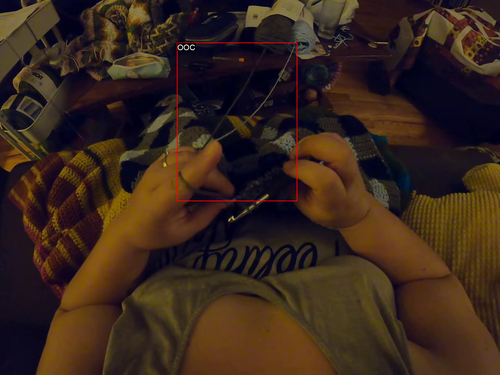

--------------------------------------------------


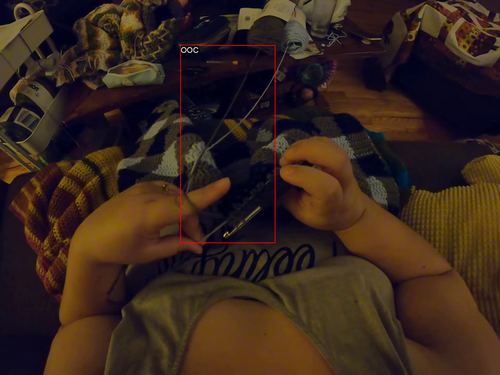

--------------------------------------------------


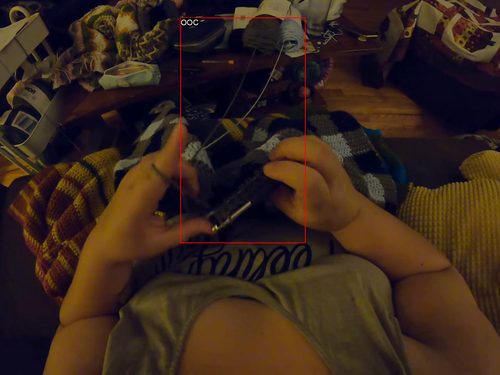

--------------------------------------------------


In [18]:
rand_idx = np.random.randint(len(downloaded_scod_clips[split]))
resize_image_width = 300

sampled_scod_clip = downloaded_scod_clips[split][rand_idx]
video_uid = curr_scod_clip["video_uid"]
print("Mother video: {}".format(video_uid))

closest_narrations = get_scod_clipped_narrations(
    sampled_scod_clip,
    all_narrations,
    curr_videos_root="/local1/hu528/ego4d_data/v1/full_scale",
    narration_pass="narration_pass_1",
    anchor_frame="pnr",
    top_k=5,
    strict_overlapping=False,
    verbose=False,
    show_all_narrations=False,
)
narration = None
if len(closest_narrations) > 0:
    closest_narration = closest_narrations[0][-1]
    narration = refine_or_trim_ego4d_narration(closest_narration)

plot_gt_bboxes_for_single_scod_clip(
    sampled_scod_clip,
    resize_image_width=500,
    image_root="/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge/pre_pnr_post_frames/",
    pre_generated_captions=pre_generated_captions_trainval,
    narration=narration,
)

### If know the keyed-id

--------------------------------------------------


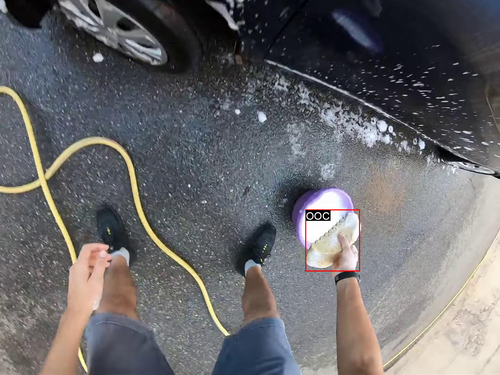

--------------------------------------------------


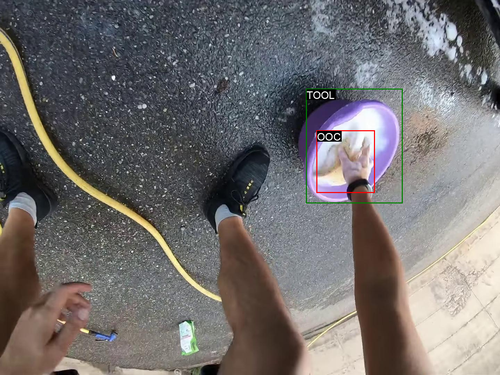

--------------------------------------------------


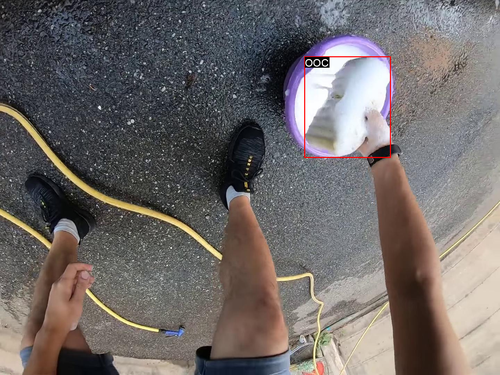

--------------------------------------------------


In [15]:
ego_id = "12bf3659-40c4-4094-a4d3-507ec04bc512_10780_10811_10929"
ego_id = "c396d137-e956-4a7f-ab2e-5a0b29c51afa_14702_14712_14782"

if ego_id == "c396d137-e956-4a7f-ab2e-5a0b29c51afa_14702_14712_14782":
    keyed_clips[ego_id]["pnr_frame"]["bbox"].append({
        "bbox": {"height": 330.4, "width": 278.37, "x": 881.23, "y": 255.23},
        "object_type": "tool",
    })

plot_gt_bboxes_for_single_scod_clip(
    keyed_clips[ego_id],
    resize_image_width=500,
    image_root="/local1/telinwu/research/resources/Ego4D/ego4d_scod_challenge/pre_pnr_post_frames/",
    pre_generated_captions=None,
    narration=None,
)

if ego_id == "c396d137-e956-4a7f-ab2e-5a0b29c51afa_14702_14712_14782":
    keyed_clips[ego_id]["pnr_frame"]["bbox"].pop(-1)

# END